In [1]:
from ImpVolPricingPlotStrategy import ImpliedVolPricingPlotStrategy
from backtest import backtest_market
from useful_functions import implied_vol_binary

In [2]:
import numpy as np
import pandas as pd
import json
import os
import datetime as dt
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
path = "btc_contracts-2"
contract_data_files = os.listdir(path)
contract_slugs = [filename.split(".")[0] for filename in contract_data_files]

In [4]:
t = contract_slugs[0]
t

'btc-updown-15m-1762093800'

In [5]:
path = "btc_contracts-2"
contract_data_files = os.listdir(path)
contract_slugs = [filename.split(".")[0] for filename in contract_data_files][:1]

# last = {}
for market_slug in tqdm(contract_slugs):
    
    # Crypto data doesn't matter for this strategy, so we'll just leave it
    crypto_data_filepath = "Chainlink_prices/"
    crypto_data_filename = "chainlink_crypto_prices_2025-11-02.jsonl"

    market_data_filepath = f"{path}/"
    crypto_symbol = "btc/usd"
    # market_slug = "btc-updown-15m-1761786000"

    # millisecond unix precision
    start_time_s = int(market_slug.split("-")[-1])
    start_time_ms = start_time_s*1000
    end_time_ms = (start_time_s + 900)*1000

    warm_up_duration = 0 # 5 minutes in milliseconds?
    time_precision = 13 # in millisecond format (10 = second format)
    
    strategy = ImpliedVolPricingPlotStrategy(start_time_ms, end_time_ms, time_precision=13, effective_memory=300)
    
    print(f"\n\nSTARTING WORK FOR MARKET: {market_slug}\n\n")
    warm_up_data, backtest_data = backtest_market(crypto_data_filepath, crypto_data_filename, crypto_symbol,
                                market_data_filepath, market_slug,
                                start_time_ms, end_time_ms,
                                warm_up_duration,
                                strategy,
                                time_precision=13 
                            )

    # up_down_market_data[market_slug] = backtest_data[-1]

  0%|          | 0/1 [00:00<?, ?it/s]



STARTING WORK FOR MARKET: btc-updown-15m-1762093800




/Users/willneuner/Desktop/FINTECH535/crypto-pred-mrkt-arb/useful_functions.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(S/X) + (r - (vol**2)/2) * T) / (vol * np.sqrt(T))


[CROSS WARNING] Book crossed at 1762094461906: bid=0.93, ask=0.92


100%|██████████| 1/1 [00:08<00:00,  8.74s/it]


In [11]:
backtest_df = pd.DataFrame(backtest_data)

In [12]:
backtest_df.iloc[2000:2002]

,timestamp,crypto_price,strike_price,tte,vol,market_spread,best_bid,best_ask,theo_price,mid_price,lwm_price,bid_data,ask_data,bid_implied_vol,ask_implied_vol,mid_implied_vol
2000,1762093871086,110342.068425,110285.694538,0.000026,0.130459,0.03,0.62,0.65,0.777987,0.635,0.64027,"{0.62: 50.0, 0.61: 5.0, 0.6: 55.0, 0.59: 50.0,...","{0.65: 24.0, 0.66: 5.0, 0.67: 76.0, 0.68: 56.0...",0.326128,0.258815,0.288836
2001,1762093871087,110342.068425,110285.694538,0.000026,0.130459,0.03,0.62,0.65,0.777987,0.635,0.64027,"{0.62: 50.0, 0.61: 5.0, 0.6: 55.0, 0.59: 50.0,...","{0.65: 24.0, 0.66: 5.0, 0.67: 76.0, 0.68: 56.0...",0.326128,0.258815,0.288836


In [22]:
np.percentile(backtest_df['mid_implied_vol'].dropna(), 100)

np.float64(3.5322598897586897)

In [35]:
backtest_df['bid_implied_vol'] = backtest_df['bid_implied_vol'].clip(0, 2.0)
backtest_df['ask_implied_vol'] = backtest_df['ask_implied_vol'].clip(0, 2.0)
backtest_df['mid_implied_vol'] = backtest_df['mid_implied_vol'].clip(0, 2.0)

In [30]:
# backtest_df[abs(backtest_df['bid_implied_vol'] -  21) < 1].head(2)

In [31]:
# backtest_df.iloc[5318:5322]

In [33]:
# row = backtest_df[abs(backtest_df['bid_implied_vol'] -  21) < 1].iloc[0]
# S = row['crypto_price']
# X = row['strike_price']
# T = row['tte']
# r = 0.042
# price = row['best_bid']
# anchor_vol = 0.3
# print(S, X, T, r, price, anchor_vol)
# implied_vol_binary(S, X, T, r, price, anchor_vol, dist_weight = 10)

In [37]:
backtest_df = backtest_df[backtest_df['bid_implied_vol'] < 1.0]

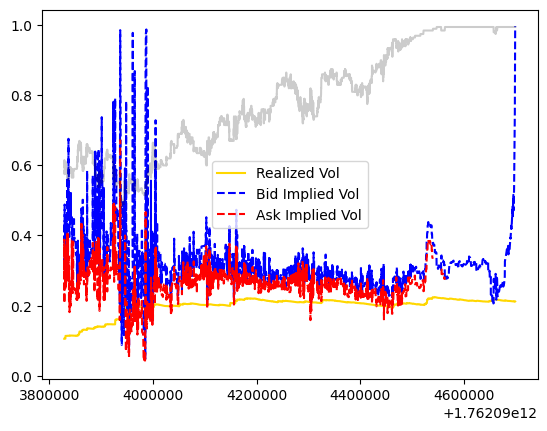

In [49]:
timestamps = backtest_df['timestamp']
plt.plot(timestamps, backtest_df['vol'], color = "gold", label="Realized Vol")
plt.plot(timestamps, backtest_df['bid_implied_vol'], color = "blue", ls = "--", label="Bid Implied Vol")
plt.plot(timestamps, backtest_df['ask_implied_vol'], color = "red", ls = "--", label="Ask Implied Vol")
plt.plot(timestamps, backtest_df['mid_price'], color = "black", alpha=0.2)
# plt.plot(timestamps, backtest_df['mid_implied_vol'], color = "black", ls = "--", label="Bid Implied Vol")
plt.legend()

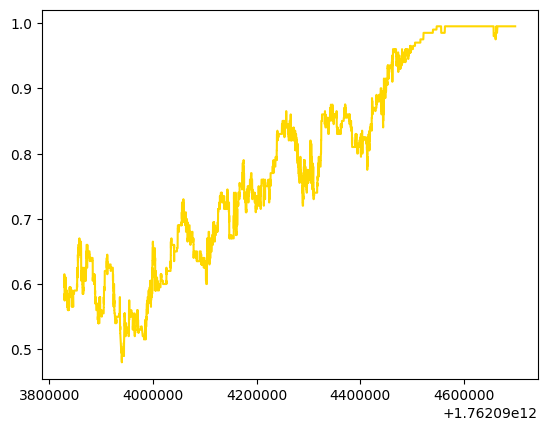

In [42]:
strategy.strike_price, strategy.resolve_price

(110285.69453814422, 110331.2510670409)